<h1>BI LSTM remove outlier with zscore</h1>

In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.losses import MeanSquaredError
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from scipy import stats
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from IPython.core.interactiveshell import InteractiveShell

# LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import Dropout, LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.model_selection import ParameterSampler
from scipy.stats import skew


InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
sns.set()
pd.options.display.max_rows = 100

<h4>Importing Datasets</h4>

In [39]:
# Import dataset and clean, ready as a dataframe for creating keys
def createDF(datasets):
    df = pd.read_csv(datasets, converters={'PARTY_ID': str, 'COM_ID': str, 'CNTR_SIZE': str})

    # Formating to type and remove NaN values
    df['POD'] = pd.to_datetime(df['POD'])
    df['ENCODED_TYPE'] = df['ENCODED_TYPE'].fillna(-1).astype(int)
    df = df.dropna(subset=['ENCODED_TYPE'])
    df['RATE'] = df['RATE'].fillna(-1).astype(float)
    df = df.dropna(subset=['RATE'])
    df['ENCODED_TYPE'] = df['ENCODED_TYPE'].astype(int)
    df_clean= df.dropna().reset_index(drop=True)

    # Selecting and rearranging columns
    sel_col = ['CSL_ID', 'CNTR_ID','POD_ID','ETD_POL_D','PARTY_ID',
            'PARTY_NAME','POD','CNTR_SIZE','CNTR_TYPE','RATE']
    df_fc = df_clean[sel_col]

    # Removing years we do not want to process in our models
    df_filtered = df_fc[df_fc['POD'].dt.year != 2002]

    # Sorting the dates
    df_filtered = df_filtered.sort_values(by='POD').reset_index(drop=True)
    
    return df_filtered

In [40]:
# Create Dataframes for old and new
old_data = '.\Datasets\CR_COST_FC.csv'
df1 = createDF(old_data)
df1.head()

new_data = '.\Datasets\CR_COST_FC_new.csv'
df2 = createDF(new_data)
df2.head()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS01050600224,CTNR010050700354,ROTTERDAM,NLRTM,01008827,YANG MING (SINGAPORE) PTE. LTD.,2005-07-15,40,HC NOR,1620.0
1,ECS01050600610,CTNR010050700353,FELIXSTOWE,GBFXT,01002303,GLOBELINK FALLOW LIMITED,2005-07-15,40,GP,1800.0
2,ECS01050600041,CTNR010050700351,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-15,40,HC NOR,2170.0
3,ECS01050600163,CTNR010050700370,PASIR GUDANG,MYPGU,01002767,GLOBELINK CONTAINER LINES (JB) S/B,2005-07-15,40,HC,280.0
4,ECS01050600456,CTNR010050700450,KARACHI (KICT),PKKHI,01002783,GLOBELINK PAKISTAN (PVT) LTD,2005-07-16,40,HC,1625.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS01050600224,CTNR010050700354,ROTTERDAM,NLRTM,01008827,YANG MING (SINGAPORE) PTE. LTD.,2005-07-15,40,HC NOR,1620.0
1,ECS01050600610,CTNR010050700353,FELIXSTOWE,GBFXT,01002303,GLOBELINK FALLOW LIMITED,2005-07-15,40,GP,1800.0
2,ECS01050600041,CTNR010050700351,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-15,40,HC NOR,2170.0
3,ECS01050600163,CTNR010050700370,PASIR GUDANG,MYPGU,01002767,GLOBELINK CONTAINER LINES (JB) S/B,2005-07-15,40,HC,280.0
4,ECS01050600456,CTNR010050700450,KARACHI (KICT),PKKHI,01002783,GLOBELINK PAKISTAN (PVT) LTD,2005-07-16,40,HC,1625.0


<h4>Creating Dictionary Keys</h4>

In [41]:
def filter_dataframe(df):
    filtered_dataframes = {}

    for (port, size, ctype, party_id), group in df.groupby(['POD_ID', 'CNTR_SIZE', 'CNTR_TYPE', 'PARTY_ID']):
        group = group.reset_index(drop=True).sort_values(by='POD')
        df_id = f"Port_{port}_Size_{size}_Type_{ctype}_PartyID_{party_id}"
        filtered_dataframes[df_id] = group

    return filtered_dataframes

In [42]:
# Creating keys from data
print("Old Data keys:")
filtered_dataframe1 = filter_dataframe(df1)
df_ids1 = list(filtered_dataframe1.keys())
print(list(df_ids1))
print(len(list(df_ids1)))

print("\nNew Data keys:")
filtered_dataframe2 = filter_dataframe(df2)
df_ids2 = list(filtered_dataframe2.keys())
print(list(df_ids2))
print(len(list(df_ids2)))

Old Data keys:
['Port_(CONSTANZA)_Size_40_Type_GP_PartyID_010007816', 'Port_(CONSTANZA)_Size_40_Type_HC_PartyID_010007816', 'Port_AARHUS_Size_20_Type_GP_PartyID_01000043', 'Port_AARHUS_Size_20_Type_GP_PartyID_0100027830', 'Port_AARHUS_Size_20_Type_GP_PartyID_010006666', 'Port_AARHUS_Size_40_Type_GP_PartyID_01000043', 'Port_AARHUS_Size_40_Type_HC_PartyID_01000043', 'Port_AARHUS_Size_40_Type_HC_PartyID_0100027830', 'Port_AARHUS_Size_40_Type_HC_PartyID_0100028193', 'Port_AARHUS_Size_40_Type_HC_PartyID_010006666', 'Port_ABIDJAN_Size_20_Type_GP_PartyID_0100027878', 'Port_ABIDJAN_Size_40_Type_HC_PartyID_010021097', 'Port_ADELAIDE_Size_20_Type_GP_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_GP_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_HC_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_HC_PartyID_01005078', 'Port_ADELAIDE_Size_40_Type_HC NOR_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_20_Type_GP_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_40_Type_HC_PartyID_01002775', 'Port_ADELAIDE(AU)_Si

<h4>Getting Top 5 ports keys</h4>

In [43]:
def getTop5Ports(keybunch):
    keybunch_pouch = []
    
    # Get a dictionary with key and number of rows for each dataframe in filtered_dataframes
    key_row_counts = {key: len(keybunch[key]) for key in keybunch}

    # Sort the key_row_counts dictionary by value (number of rows) in descending order
    sorted_key_row_counts = sorted(key_row_counts.items(), key=lambda item: item[1], reverse=True)

    # Get the top 5 keys with the most rows
    top_5_keys_tuple = sorted_key_row_counts[:5]

    # Create a dictionary with the top 5 keys and their corresponding dataframes (with up to 5 rows per dataframe)
    keybunch_subset = {}

    for key, row_count in top_5_keys_tuple:
        keybunch_subset[key] = keybunch[key][:5]
        print(f"Number of rows in {key}: {row_count}")
        keybunch_pouch.append(key)
    
    # Return array of keys
    return keybunch_pouch

In [44]:
print('Old Dataset Keybunch:')
old_df = getTop5Ports(filtered_dataframe1)
print('\n')

print('New Dataset Keybunch:')
new_df = getTop5Ports(filtered_dataframe2)

Old Dataset Keybunch:
Number of rows in Port_BUSAN_Size_40_Type_HC_PartyID_010004286: 1689
Number of rows in Port_AUCKLAND_Size_40_Type_HC_PartyID_01005136: 1688
Number of rows in Port_MELBOURNE_Size_40_Type_HC_PartyID_01002778: 1325
Number of rows in Port_SYDNEY_Size_40_Type_HC_PartyID_01002779: 1300
Number of rows in Port_DUBAI (JEBEL ALI)_Size_40_Type_HC_PartyID_01002788: 1052


New Dataset Keybunch:
Number of rows in Port_BUSAN_Size_40_Type_HC_PartyID_010004286: 1712
Number of rows in Port_AUCKLAND_Size_40_Type_HC_PartyID_01005136: 1704
Number of rows in Port_MELBOURNE_Size_40_Type_HC_PartyID_01002778: 1341
Number of rows in Port_SYDNEY_Size_40_Type_HC_PartyID_01002779: 1308
Number of rows in Port_DUBAI (JEBEL ALI)_Size_40_Type_HC_PartyID_01002788: 1070


In [45]:
# Global selection
sel_country = old_df[2]

# Accessing the highest count in the each keypouch, new and old.
sel_df = filtered_dataframe1[sel_country]
sel_df.head(5)
sel_df.tail(5)
sel_df.info()
print("\n")

latest_sel_df = filtered_dataframe2[sel_country]
latest_sel_df.head(5)
latest_sel_df.tail(5)
latest_sel_df.info()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS01050600278,CTNR010050700692,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2005-07-23,40,HC,1200.0
1,ECS01050600280,CTNR010050701022,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2005-07-30,40,HC,1200.0
2,ECS010050700458,CTNR010050800604,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2005-08-16,40,HC,1000.0
3,ECS010050700214,CTNR010050800727,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2005-08-19,40,HC,1200.0
4,ECS010050900271,CTNR010051000178,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2005-10-11,40,HC,900.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
1320,ECS010230100302,010000357415,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-02-11,40,HC,1200.0
1321,ECS010230100303,010000380481,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-02-16,40,HC,1200.0
1323,ECS010230100304,010000392586,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-02-24,40,HC,1200.0
1322,ECS010230100304,010000390964,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-02-24,40,HC,1200.0
1324,ECS010230100304,010000399293,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-02-24,40,HC,1200.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1325 entries, 0 to 1324
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      1325 non-null   object        
 1   CNTR_ID     1325 non-null   object        
 2   POD_ID      1325 non-null   object        
 3   ETD_POL_D   1325 non-null   object        
 4   PARTY_ID    1325 non-null   object        
 5   PARTY_NAME  1325 non-null   object        
 6   POD         1325 non-null   datetime64[ns]
 7   CNTR_SIZE   1325 non-null   object        
 8   CNTR_TYPE   1325 non-null   object        
 9   RATE        1325 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 113.9+ KB




,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS01050600278,CTNR010050700692,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2005-07-23,40,HC,1200.0
1,ECS01050600280,CTNR010050701022,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2005-07-30,40,HC,1200.0
2,ECS010050700458,CTNR010050800604,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2005-08-16,40,HC,1000.0
3,ECS010050700214,CTNR010050800727,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2005-08-19,40,HC,1200.0
4,ECS010050900271,CTNR010051000178,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2005-10-11,40,HC,900.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
1336,ECS010230300518,010000531211,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-04-28,40,HC,500.0
1337,ECS010230300518,010000509487,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-04-28,40,HC,500.0
1338,ECS010230400431,010000541165,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-05-05,40,HC,500.0
1339,ECS010230400432,010000543217,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-05-11,40,HC,500.0
1340,ECS010230400433,010000557443,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-05-19,40,HC,400.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1341 entries, 0 to 1340
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      1341 non-null   object        
 1   CNTR_ID     1341 non-null   object        
 2   POD_ID      1341 non-null   object        
 3   ETD_POL_D   1341 non-null   object        
 4   PARTY_ID    1341 non-null   object        
 5   PARTY_NAME  1341 non-null   object        
 6   POD         1341 non-null   datetime64[ns]
 7   CNTR_SIZE   1341 non-null   object        
 8   CNTR_TYPE   1341 non-null   object        
 9   RATE        1341 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 115.2+ KB


In [46]:
# Select features
sel_feat = ['POD','RATE']
sel_feat_df = sel_df[sel_feat].copy()  # make a copy to avoid SettingWithCopyWarning

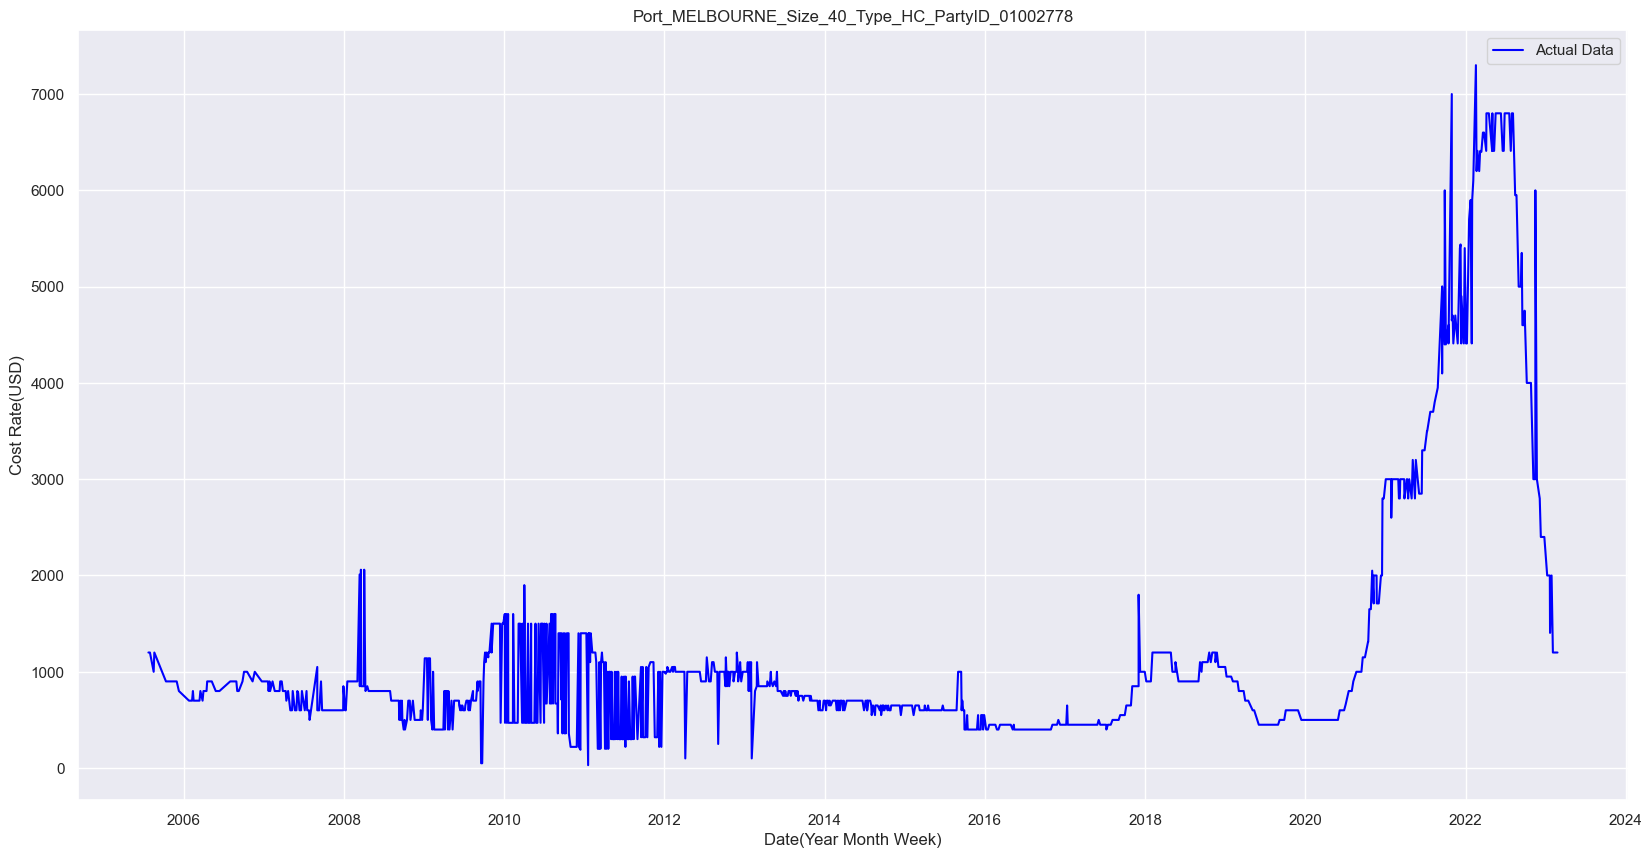

In [47]:
plt.figure(figsize=(20, 10))
plt.plot(sel_feat_df['POD'], sel_feat_df['RATE'], color='blue', label="Actual Data")

plt.xlabel('Date(Year Month Week)')
plt.ylabel('Cost Rate(USD)')
plt.title(sel_country)
plt.legend()
plt.show();

<h4>Remove Outliers</h4>

In [48]:
# Assuming 'robust_df' is your DataFrame and 'RATE' is the column containing the data
z_scores = stats.zscore(sel_feat_df[['RATE']])
threshold = 3  # Z-score threshold for outlier detection

# Find indices of outliers
outlier_indices = np.where(np.abs(z_scores) > threshold)[0]

# Remove outliers
robust_df = sel_feat_df.drop(sel_feat_df.index[outlier_indices])

# Reset the index
robust_df.reset_index(drop=True, inplace=True)

# Print the modified DataFrame
robust_df.head()
robust_df.info()


,POD,RATE
0,2005-07-23,1200.0
1,2005-07-30,1200.0
2,2005-08-16,1000.0
3,2005-08-19,1200.0
4,2005-10-11,900.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1275 entries, 0 to 1274
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   POD     1275 non-null   datetime64[ns]
 1   RATE    1275 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 20.0 KB


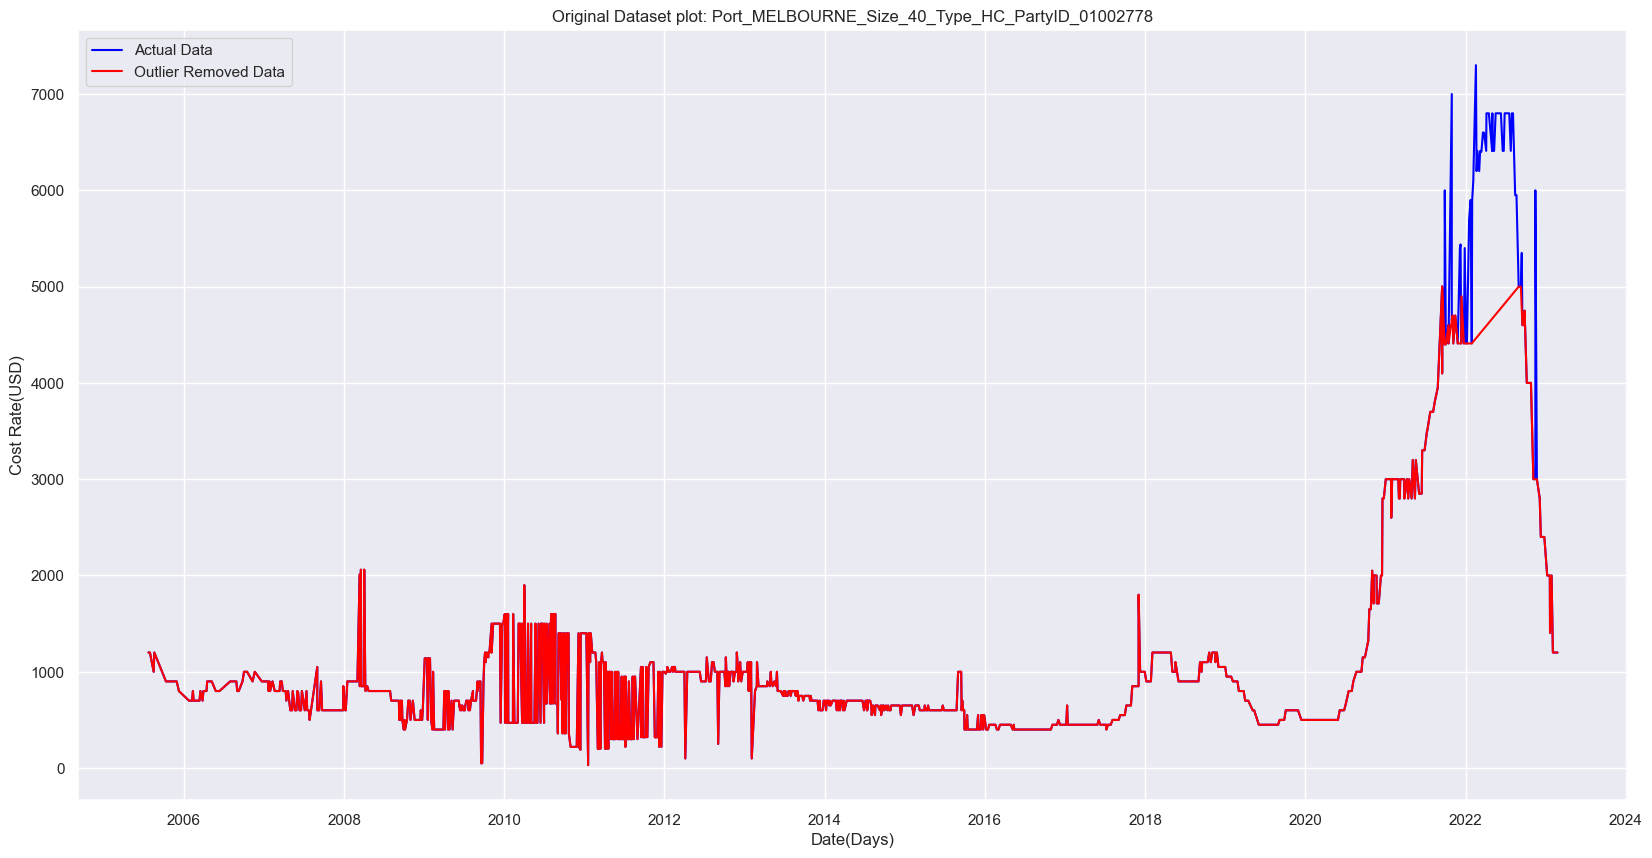

In [49]:
plt.figure(figsize=(20, 10))
plt.plot(sel_feat_df['POD'], sel_feat_df['RATE'], color='blue', label="Actual Data")
plt.plot(robust_df['POD'], robust_df['RATE'], color='red', label="Outlier Removed Data")

plt.xlabel('Date(Days)')
plt.ylabel('Cost Rate(USD)')
plt.title(f'Original Dataset plot: {sel_country}')
plt.legend()
plt.show();

<h4>Interpolate missing values in between dates</h4>

In [50]:
# Remove duplicated dates and cost rows
robust_df = robust_df.drop_duplicates(subset=['POD', 'RATE']).reset_index(drop=True)

# Create a new dataframe with a date range from min to max date in your dataframe
new_df = pd.DataFrame()
new_df['POD'] = pd.date_range(start=robust_df['POD'].min(), end=robust_df['POD'].max())

# Merge the original dataframe with the new one. Missing dates in the original dataframe will be filled with NaN
df_interpolated = pd.merge(new_df, robust_df, on='POD', how='left')  

# Perform spline interpolation
df_interpolated['RATE'] = df_interpolated['RATE'].interpolate(method='polynomial', order=1)

df_interpolated['RATE'] = df_interpolated['RATE'].round(3)

df_interpolated.head(5)
df_interpolated.tail(5)
df_interpolated.info()

,POD,RATE
0,2005-07-23,1200.0
1,2005-07-24,1200.0
2,2005-07-25,1200.0
3,2005-07-26,1200.0
4,2005-07-27,1200.0


,POD,RATE
6438,2023-02-20,1200.0
6439,2023-02-21,1200.0
6440,2023-02-22,1200.0
6441,2023-02-23,1200.0
6442,2023-02-24,1200.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6443 entries, 0 to 6442
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   POD     6443 non-null   datetime64[ns]
 1   RATE    6443 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 151.0 KB


<h4>Grouping it to week</h4>

In [51]:
# Create YearMonthWeek directly from the 'POD'
df_interpolated['YearMonthWeek'] = df_interpolated['POD'] - pd.to_timedelta(df_interpolated['POD'].dt.dayofweek, unit='D')

# Create a new dataframe with every week in the range
all_weeks = pd.date_range(start=df_interpolated['POD'].min(), end=df_interpolated['POD'].max(), freq='W')
all_weeks_df = pd.DataFrame(all_weeks, columns=['POD'])

# Create YearMonthWeek in all_weeks_df
all_weeks_df['YearMonthWeek'] = all_weeks_df['POD'] - pd.to_timedelta(all_weeks_df['POD'].dt.dayofweek, unit='D')

# Merge this with your original dataframe
merged_df = pd.merge(all_weeks_df, df_interpolated, on=['YearMonthWeek'], how='left')

# Now you can group by YearMonthWeek and compute your rate
grouped = merged_df.groupby(['YearMonthWeek'])

agg_df = pd.DataFrame(columns=['YearMonthWeek', 'Rate'])

for group_name, group_df in grouped:
    year_month_week = group_name

    # Skip if no data for this week
    if group_df['RATE'].isnull().all():
        continue

    # Calculate sum and skewness of RATE values
    rate_sum = group_df['RATE'].sum()
    rate_skew = group_df['RATE'].skew()

    # Calculate trimmed mean of RATE values
    rate_metric = stats.trim_mean(group_df['RATE'].dropna().values, 0.1) # trimming 10% from each end

    new_row = {
        'YearMonthWeek': year_month_week,
        'Rate': rate_metric
    }

    # Append row to aggregated dataframe
    agg_df = agg_df.append(new_row, ignore_index=True)

agg_df = agg_df.sort_values(by='YearMonthWeek').reset_index(drop=True)
agg_df['Rate'] = agg_df['Rate'].round(2)

agg_df.head(15)
agg_df.tail(15)
agg_df.info()


C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_42164\545048384.py:19: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for group_name, group_df in grouped:
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_42164\545048384.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  agg_df = agg_df.append(new_row, ignore_index=True)
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_42164\545048384.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  agg_df = agg_df.append(new_row, ignore_index=True)
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_42164\545048384.py:39: FutureWarning: The frame.append method is deprecated and will be remov

,YearMonthWeek,Rate
0,2005-07-18,1200.00
1,2005-07-25,1198.32
2,2005-08-01,1141.18
3,2005-08-08,1058.82
4,2005-08-15,1113.54
5,2005-08-22,1166.04
6,2005-08-29,1126.42
7,2005-09-05,1086.79
8,2005-09-12,1047.17
9,2005-09-19,1007.55


,YearMonthWeek,Rate
903,2022-11-07,3000.00
904,2022-11-14,3000.00
905,2022-11-21,2967.03
906,2022-11-28,2861.54
907,2022-12-05,2571.43
908,2022-12-12,2400.00
909,2022-12-19,2400.00
910,2022-12-26,2307.69
911,2023-01-02,2092.31
912,2023-01-09,2000.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   YearMonthWeek  918 non-null    datetime64[ns]
 1   Rate           918 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 14.5 KB


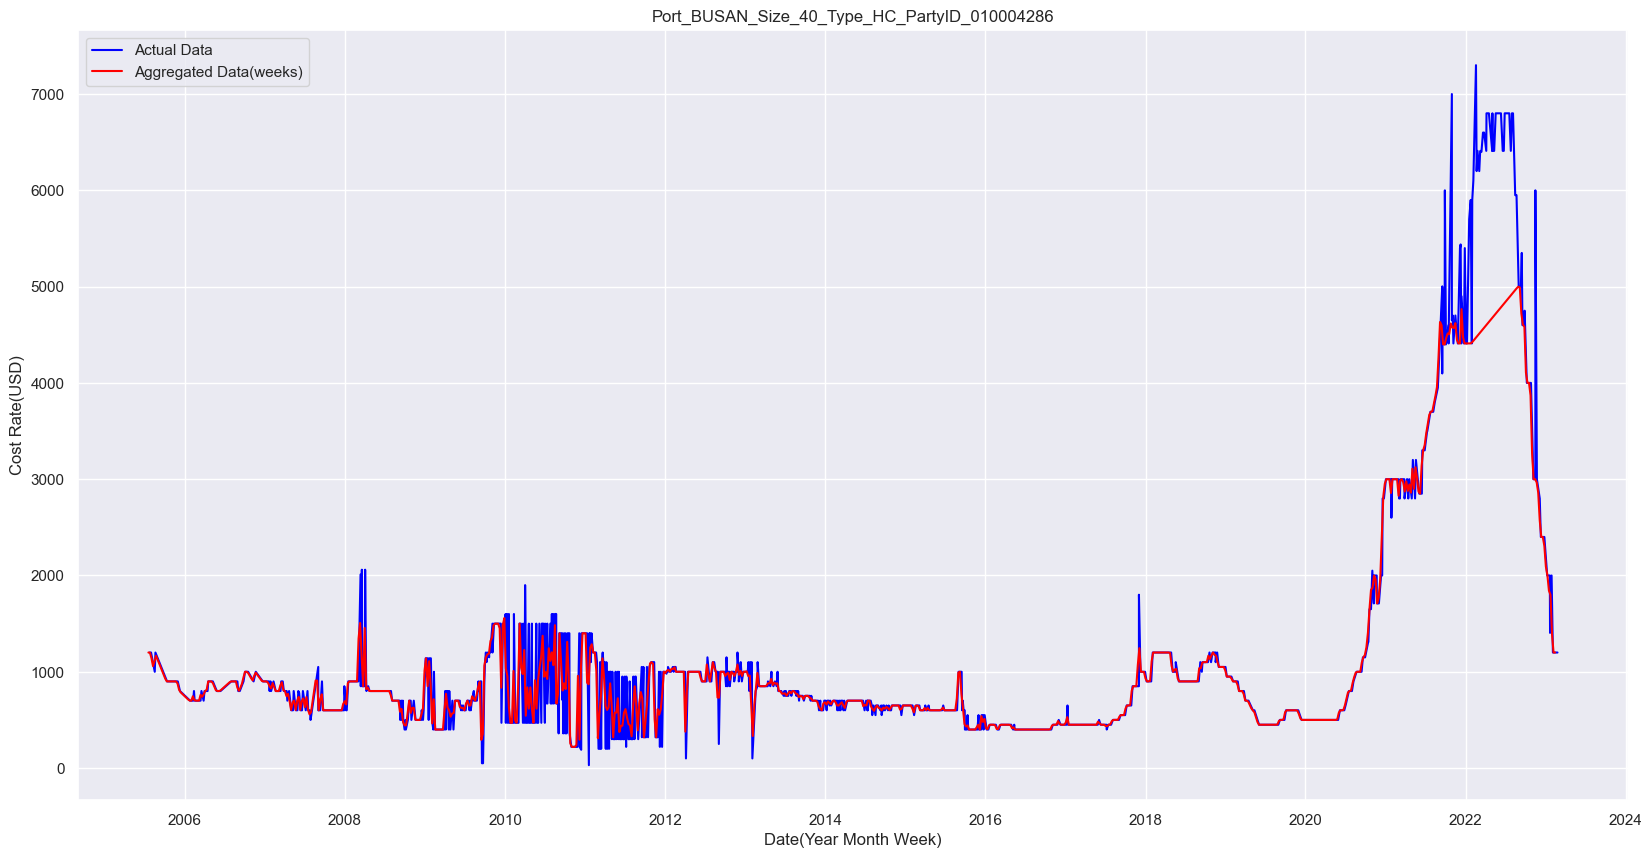

In [52]:
plt.figure(figsize=(20, 10))
plt.plot(sel_df['POD'], sel_df['RATE'], color='blue', label="Actual Data")
plt.plot(agg_df['YearMonthWeek'], agg_df['Rate'], color='red', label="Aggregated Data(weeks)")

plt.xlabel('Date(Year Month Week)')
plt.ylabel('Cost Rate(USD)')
plt.title('Port_BUSAN_Size_40_Type_HC_PartyID_010004286')
plt.legend()
plt.show();

<h4>Latest datapoints from Latest dataframe for comparing after forecasting (Measure accuracy)</h4>

In [53]:
max_date_in_old = sel_df['POD'].max()

# Create a new dataframe that only includes rows from the latest dataframe where the date is greater than the maximum date in the old dataframe
new_dates_df = latest_sel_df[latest_sel_df['POD'] > max_date_in_old].reset_index(drop=True)

# Print the new dataframe
new_dates_df.head(3)
new_dates_df.tail(3)
new_dates_df.info()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS010230200328,010000409869,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-03-02,40,HC,1000.0
1,ECS010230200329,010000419018,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-03-10,40,HC,1000.0
2,ECS010230200330,010000427048,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-03-16,40,HC,1000.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
13,ECS010230400431,010000541165,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-05-05,40,HC,500.0
14,ECS010230400432,010000543217,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-05-11,40,HC,500.0
15,ECS010230400433,010000557443,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-05-19,40,HC,400.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      16 non-null     object        
 1   CNTR_ID     16 non-null     object        
 2   POD_ID      16 non-null     object        
 3   ETD_POL_D   16 non-null     object        
 4   PARTY_ID    16 non-null     object        
 5   PARTY_NAME  16 non-null     object        
 6   POD         16 non-null     datetime64[ns]
 7   CNTR_SIZE   16 non-null     object        
 8   CNTR_TYPE   16 non-null     object        
 9   RATE        16 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 1.4+ KB


<h4>LSTM Regression<h4>

In [54]:
# Mean Square Error Function:
def calculate_RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Update create_dataset to handle multi-feature dataset
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)


def create_LSTM_model(trainX, trainY, testX, testY, epochs, lstm_layers):
    model = Sequential()
    
    for i in range(len(lstm_layers)):
        if i == 0:
            # First layer specifies the input_shape and returns sequences
            model.add(LSTM(lstm_layers[i], return_sequences=True, input_shape=(look_back, trainX.shape[2]), 
                           activation='tanh', recurrent_activation='hard_sigmoid', kernel_regularizer=l2(0.01)))
        elif i == len(lstm_layers) - 1:
            # Last layer doesn't return sequences
            model.add(LSTM(lstm_layers[i], activation='tanh', kernel_regularizer=l2(0.01)))
        else:
            # Middle layers return sequences
            model.add(LSTM(lstm_layers[i], return_sequences=True, activation='tanh', 
                           recurrent_activation='hard_sigmoid', kernel_regularizer=l2(0.01)))
        model.add(Dropout(0.2))
        
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.0005))
    model.summary()

    # Add early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
    
    # Fit the model and store the history
    history = model.fit(trainX, trainY, epochs=epochs, batch_size=128, verbose=2, 
                        validation_data=(testX, testY), callbacks=[es])
    return model, history


def plot_train_val_loss(history):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model loss progress during training and validation')
    plt.xlabel('Epoch')
    plt.ylabel('Training and Validation Loss')
    plt.legend()
    plt.show()

Training for 50 epochs...
Training with LSTM layers: [64, 64, 32, 32, 16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 64)             16896     
                                                                 
 dropout (Dropout)           (None, 5, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 64)             33024     
                                                                 
 dropout_1 (Dropout)         (None, 5, 64)             0         
                                                                 
 lstm_2 (LSTM)               (None, 5, 32)             12416     
                                                                 
 dropout_2 (Dropout)         (None, 5, 32)             0         
                          

9/9 [==============================] - 0s 6ms/step
Train Score: 246.91 RMSE for 50 epochs
Test Score: 2118.67 RMSE for 50 epochs
Training with LSTM layers: [32, 32, 16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 5, 32)             4352      
                                                                 
 dropout_12 (Dropout)        (None, 5, 32)             0         
                                                                 
 lstm_13 (LSTM)              (None, 5, 32)             8320      
                                                                 
 dropout_13 (Dropout)        (None, 5, 32)             0         
                                                                 
 lstm_14 (LSTM)              (None, 5, 16)             3136      
                                                             

9/9 [==============================] - 0s 4ms/step
Train Score: 247.25 RMSE for 50 epochs
Test Score: 2120.70 RMSE for 50 epochs
Training with LSTM layers: [16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 5, 16)             1152      
                                                                 
 dropout_22 (Dropout)        (None, 5, 16)             0         
                                                                 
 lstm_23 (LSTM)              (None, 5, 16)             2112      
                                                                 
 dropout_23 (Dropout)        (None, 5, 16)             0         
                                                                 
 lstm_24 (LSTM)              (None, 5, 8)              800       
                                                                 
 dr

9/9 [==============================] - 0s 4ms/step
Train Score: 246.85 RMSE for 50 epochs
Test Score: 2118.25 RMSE for 50 epochs
Training with LSTM layers: [8, 8, 4, 4, 2, 2]
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 5, 8)              320       
                                                                 
 dropout_30 (Dropout)        (None, 5, 8)              0         
                                                                 
 lstm_31 (LSTM)              (None, 5, 8)              544       
                                                                 
 dropout_31 (Dropout)        (None, 5, 8)              0         
                                                                 
 lstm_32 (LSTM)              (None, 5, 4)              208       
                                                                 
 dropout_32

9/9 [==============================] - 0s 3ms/step
Train Score: 247.39 RMSE for 50 epochs
Test Score: 2121.48 RMSE for 50 epochs
Training with LSTM layers: [4, 4, 2, 2]
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 5, 4)              96        
                                                                 
 dropout_36 (Dropout)        (None, 5, 4)              0         
                                                                 
 lstm_37 (LSTM)              (None, 5, 4)              144       
                                                                 
 dropout_37 (Dropout)        (None, 5, 4)              0         
                                                                 
 lstm_38 (LSTM)              (None, 5, 2)              56        
                                                                 
 dropout_38 (Drop

9/9 [==============================] - 0s 2ms/step
Train Score: 246.94 RMSE for 50 epochs
Test Score: 2119.00 RMSE for 50 epochs
Training with LSTM layers: [2, 2]
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 5, 2)              32        
                                                                 
 dropout_40 (Dropout)        (None, 5, 2)              0         
                                                                 
 lstm_41 (LSTM)              (None, 2)                 40        
                                                                 
 dropout_41 (Dropout)        (None, 2)                 0         
                                                                 
 dense_5 (Dense)             (None, 1)                 3         
                                                                 
Total params: 75
Traina

9/9 [==============================] - 0s 2ms/step
Train Score: 245.16 RMSE for 50 epochs
Test Score: 2097.86 RMSE for 50 epochs
Training for 100 epochs...
Training with LSTM layers: [64, 64, 32, 32, 16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_42 (LSTM)              (None, 5, 64)             16896     
                                                                 
 dropout_42 (Dropout)        (None, 5, 64)             0         
                                                                 
 lstm_43 (LSTM)              (None, 5, 64)             33024     
                                                                 
 dropout_43 (Dropout)        (None, 5, 64)             0         
                                                                 
 lstm_44 (LSTM)              (None, 5, 32)             12416     
                          

9/9 [==============================] - 0s 6ms/step
Train Score: 246.06 RMSE for 100 epochs
Test Score: 2111.78 RMSE for 100 epochs
Training with LSTM layers: [32, 32, 16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_54 (LSTM)              (None, 5, 32)             4352      
                                                                 
 dropout_54 (Dropout)        (None, 5, 32)             0         
                                                                 
 lstm_55 (LSTM)              (None, 5, 32)             8320      
                                                                 
 dropout_55 (Dropout)        (None, 5, 32)             0         
                                                                 
 lstm_56 (LSTM)              (None, 5, 16)             3136      
                                                           

9/9 [==============================] - 0s 6ms/step
Train Score: 246.17 RMSE for 100 epochs
Test Score: 2112.91 RMSE for 100 epochs
Training with LSTM layers: [16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_64 (LSTM)              (None, 5, 16)             1152      
                                                                 
 dropout_64 (Dropout)        (None, 5, 16)             0         
                                                                 
 lstm_65 (LSTM)              (None, 5, 16)             2112      
                                                                 
 dropout_65 (Dropout)        (None, 5, 16)             0         
                                                                 
 lstm_66 (LSTM)              (None, 5, 8)              800       
                                                                 
 

9/9 [==============================] - 0s 4ms/step
Train Score: 246.11 RMSE for 100 epochs
Test Score: 2112.34 RMSE for 100 epochs
Training with LSTM layers: [8, 8, 4, 4, 2, 2]
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_72 (LSTM)              (None, 5, 8)              320       
                                                                 
 dropout_72 (Dropout)        (None, 5, 8)              0         
                                                                 
 lstm_73 (LSTM)              (None, 5, 8)              544       
                                                                 
 dropout_73 (Dropout)        (None, 5, 8)              0         
                                                                 
 lstm_74 (LSTM)              (None, 5, 4)              208       
                                                                 
 dropout_

9/9 [==============================] - 0s 3ms/step
Train Score: 246.01 RMSE for 100 epochs
Test Score: 2111.18 RMSE for 100 epochs
Training with LSTM layers: [4, 4, 2, 2]
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_78 (LSTM)              (None, 5, 4)              96        
                                                                 
 dropout_78 (Dropout)        (None, 5, 4)              0         
                                                                 
 lstm_79 (LSTM)              (None, 5, 4)              144       
                                                                 
 dropout_79 (Dropout)        (None, 5, 4)              0         
                                                                 
 lstm_80 (LSTM)              (None, 5, 2)              56        
                                                                 
 dropout_80 (D

9/9 [==============================] - 0s 2ms/step
Train Score: 245.85 RMSE for 100 epochs
Test Score: 2109.21 RMSE for 100 epochs
Training with LSTM layers: [2, 2]
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_82 (LSTM)              (None, 5, 2)              32        
                                                                 
 dropout_82 (Dropout)        (None, 5, 2)              0         
                                                                 
 lstm_83 (LSTM)              (None, 2)                 40        
                                                                 
 dropout_83 (Dropout)        (None, 2)                 0         
                                                                 
 dense_11 (Dense)            (None, 1)                 3         
                                                                 
Total params: 75
Tra

9/9 [==============================] - 0s 1ms/step
Train Score: 248.55 RMSE for 100 epochs
Test Score: 2136.91 RMSE for 100 epochs
Training for 150 epochs...
Training with LSTM layers: [64, 64, 32, 32, 16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_84 (LSTM)              (None, 5, 64)             16896     
                                                                 
 dropout_84 (Dropout)        (None, 5, 64)             0         
                                                                 
 lstm_85 (LSTM)              (None, 5, 64)             33024     
                                                                 
 dropout_85 (Dropout)        (None, 5, 64)             0         
                                                                 
 lstm_86 (LSTM)              (None, 5, 32)             12416     
                       

9/9 [==============================] - 0s 6ms/step
Train Score: 245.67 RMSE for 150 epochs
Test Score: 2105.53 RMSE for 150 epochs
Training with LSTM layers: [32, 32, 16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_96 (LSTM)              (None, 5, 32)             4352      
                                                                 
 dropout_96 (Dropout)        (None, 5, 32)             0         
                                                                 
 lstm_97 (LSTM)              (None, 5, 32)             8320      
                                                                 
 dropout_97 (Dropout)        (None, 5, 32)             0         
                                                                 
 lstm_98 (LSTM)              (None, 5, 16)             3136      
                                                          

9/9 [==============================] - 0s 5ms/step
Train Score: 245.73 RMSE for 150 epochs
Test Score: 2106.96 RMSE for 150 epochs
Training with LSTM layers: [16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_106 (LSTM)             (None, 5, 16)             1152      
                                                                 
 dropout_106 (Dropout)       (None, 5, 16)             0         
                                                                 
 lstm_107 (LSTM)             (None, 5, 16)             2112      
                                                                 
 dropout_107 (Dropout)       (None, 5, 16)             0         
                                                                 
 lstm_108 (LSTM)             (None, 5, 8)              800       
                                                                 


9/9 [==============================] - 0s 4ms/step
Train Score: 245.77 RMSE for 150 epochs
Test Score: 2107.75 RMSE for 150 epochs
Training with LSTM layers: [8, 8, 4, 4, 2, 2]
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_114 (LSTM)             (None, 5, 8)              320       
                                                                 
 dropout_114 (Dropout)       (None, 5, 8)              0         
                                                                 
 lstm_115 (LSTM)             (None, 5, 8)              544       
                                                                 
 dropout_115 (Dropout)       (None, 5, 8)              0         
                                                                 
 lstm_116 (LSTM)             (None, 5, 4)              208       
                                                                 
 dropout

9/9 [==============================] - 0s 3ms/step
Train Score: 245.76 RMSE for 150 epochs
Test Score: 2107.63 RMSE for 150 epochs
Training with LSTM layers: [4, 4, 2, 2]
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_120 (LSTM)             (None, 5, 4)              96        
                                                                 
 dropout_120 (Dropout)       (None, 5, 4)              0         
                                                                 
 lstm_121 (LSTM)             (None, 5, 4)              144       
                                                                 
 dropout_121 (Dropout)       (None, 5, 4)              0         
                                                                 
 lstm_122 (LSTM)             (None, 5, 2)              56        
                                                                 
 dropout_122 (

9/9 [==============================] - 0s 2ms/step
Train Score: 245.80 RMSE for 150 epochs
Test Score: 2108.39 RMSE for 150 epochs
Training with LSTM layers: [2, 2]
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_124 (LSTM)             (None, 5, 2)              32        
                                                                 
 dropout_124 (Dropout)       (None, 5, 2)              0         
                                                                 
 lstm_125 (LSTM)             (None, 2)                 40        
                                                                 
 dropout_125 (Dropout)       (None, 2)                 0         
                                                                 
 dense_17 (Dense)            (None, 1)                 3         
                                                                 
Total params: 75
Tra

9/9 [==============================] - 0s 2ms/step
Train Score: 242.62 RMSE for 150 epochs
Test Score: 2057.18 RMSE for 150 epochs
Training for 300 epochs...
Training with LSTM layers: [64, 64, 32, 32, 16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_126 (LSTM)             (None, 5, 64)             16896     
                                                                 
 dropout_126 (Dropout)       (None, 5, 64)             0         
                                                                 
 lstm_127 (LSTM)             (None, 5, 64)             33024     
                                                                 
 dropout_127 (Dropout)       (None, 5, 64)             0         
                                                                 
 lstm_128 (LSTM)             (None, 5, 32)             12416     
                       

9/9 [==============================] - 0s 6ms/step
Train Score: 245.62 RMSE for 300 epochs
Test Score: 2102.50 RMSE for 300 epochs
Training with LSTM layers: [32, 32, 16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_138 (LSTM)             (None, 5, 32)             4352      
                                                                 
 dropout_138 (Dropout)       (None, 5, 32)             0         
                                                                 
 lstm_139 (LSTM)             (None, 5, 32)             8320      
                                                                 
 dropout_139 (Dropout)       (None, 5, 32)             0         
                                                                 
 lstm_140 (LSTM)             (None, 5, 16)             3136      
                                                          

9/9 [==============================] - 0s 5ms/step
Train Score: 245.63 RMSE for 300 epochs
Test Score: 2103.63 RMSE for 300 epochs
Training with LSTM layers: [16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_148 (LSTM)             (None, 5, 16)             1152      
                                                                 
 dropout_148 (Dropout)       (None, 5, 16)             0         
                                                                 
 lstm_149 (LSTM)             (None, 5, 16)             2112      
                                                                 
 dropout_149 (Dropout)       (None, 5, 16)             0         
                                                                 
 lstm_150 (LSTM)             (None, 5, 8)              800       
                                                                 


9/9 [==============================] - 0s 4ms/step
Train Score: 245.63 RMSE for 300 epochs
Test Score: 2103.57 RMSE for 300 epochs
Training with LSTM layers: [8, 8, 4, 4, 2, 2]
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_156 (LSTM)             (None, 5, 8)              320       
                                                                 
 dropout_156 (Dropout)       (None, 5, 8)              0         
                                                                 
 lstm_157 (LSTM)             (None, 5, 8)              544       
                                                                 
 dropout_157 (Dropout)       (None, 5, 8)              0         
                                                                 
 lstm_158 (LSTM)             (None, 5, 4)              208       
                                                                 
 dropout

9/9 [==============================] - 0s 4ms/step
Train Score: 245.62 RMSE for 300 epochs
Test Score: 2103.20 RMSE for 300 epochs
Training with LSTM layers: [4, 4, 2, 2]
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_162 (LSTM)             (None, 5, 4)              96        
                                                                 
 dropout_162 (Dropout)       (None, 5, 4)              0         
                                                                 
 lstm_163 (LSTM)             (None, 5, 4)              144       
                                                                 
 dropout_163 (Dropout)       (None, 5, 4)              0         
                                                                 
 lstm_164 (LSTM)             (None, 5, 2)              56        
                                                                 
 dropout_164 (

9/9 [==============================] - 0s 2ms/step
Train Score: 245.62 RMSE for 300 epochs
Test Score: 2101.68 RMSE for 300 epochs
Training with LSTM layers: [2, 2]
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_166 (LSTM)             (None, 5, 2)              32        
                                                                 
 dropout_166 (Dropout)       (None, 5, 2)              0         
                                                                 
 lstm_167 (LSTM)             (None, 2)                 40        
                                                                 
 dropout_167 (Dropout)       (None, 2)                 0         
                                                                 
 dense_23 (Dense)            (None, 1)                 3         
                                                                 
Total params: 75
Tra

9/9 [==============================] - 0s 2ms/step
Train Score: 245.65 RMSE for 300 epochs
Test Score: 2104.69 RMSE for 300 epochs


Text(0.5, 1.0, 'Model loss progress during training and validation')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Training and Validation Loss')

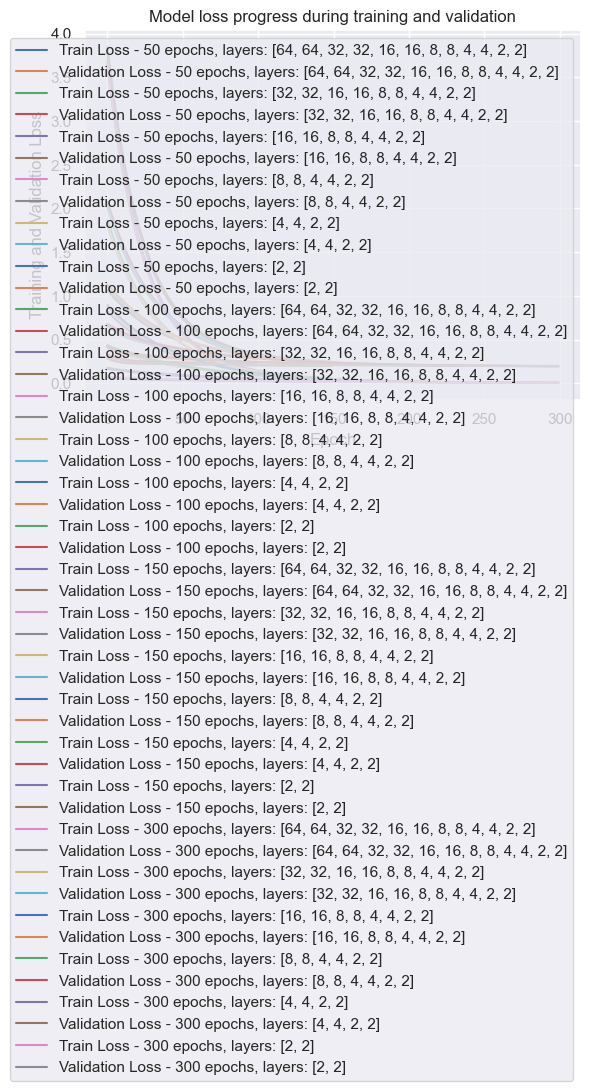

                                                    Train RMSE    Test RMSE
50 epochs, [64, 64, 32, 32, 16, 16, 8, 8, 4, 4,...  246.914814  2118.667257
50 epochs, [32, 32, 16, 16, 8, 8, 4, 4, 2, 2] l...  247.251691  2120.699864
50 epochs, [16, 16, 8, 8, 4, 4, 2, 2] layers        246.850530  2118.251031
50 epochs, [8, 8, 4, 4, 2, 2] layers                247.388905  2121.475730
50 epochs, [4, 4, 2, 2] layers                      246.937282  2119.000202
50 epochs, [2, 2] layers                            245.159845  2097.864434
100 epochs, [64, 64, 32, 32, 16, 16, 8, 8, 4, 4...  246.059419  2111.776607
100 epochs, [32, 32, 16, 16, 8, 8, 4, 4, 2, 2] ...  246.169557  2112.911337
100 epochs, [16, 16, 8, 8, 4, 4, 2, 2] layers       246.112276  2112.336891
100 epochs, [8, 8, 4, 4, 2, 2] layers               246.006432  2111.180650
100 epochs, [4, 4, 2, 2] layers                     245.849209  2109.212541
100 epochs, [2, 2] layers                           248.546611  2136.907053
150 epochs, 

In [55]:
# Normalize dataset for LSTM
from sklearn.preprocessing import MinMaxScaler

# Initialize two separate scalers
scaler_rate = MinMaxScaler(feature_range=(0, 1))

# Fit and transform 'RATE' and 'during_covid' separately
rate_scaled = scaler_rate.fit_transform(agg_df[['Rate']])

# Concatenate the scaled data
dataset = np.concatenate([rate_scaled], axis=1)

# Split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# Reshape into X=t and Y=t+1, timestep  look_back
look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], look_back, trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], look_back, testX.shape[2]))

epochs_list = [50, 100, 150, 300]

lstm_layers_list = [
    [64, 64, 32, 32, 16, 16, 8, 8, 4, 4, 2, 2],
    [32, 32, 16, 16, 8, 8, 4, 4, 2, 2],
    [16, 16, 8, 8, 4, 4, 2, 2],
    [8, 8, 4, 4, 2, 2],
    [4, 4, 2, 2],
    [2, 2]
]

rmse_results = {}

for epochs in epochs_list:
    print(f'Training for {epochs} epochs...')
    
    for lstm_layers in lstm_layers_list:
        print(f'Training with LSTM layers: {lstm_layers}')
        model, history = create_LSTM_model(trainX, trainY, testX, testY, epochs, lstm_layers)
        
        # Add the loss for this model to the plot
        plt.plot(history.history['loss'], label=f'Train Loss - {epochs} epochs, layers: {lstm_layers}')
        plt.plot(history.history['val_loss'], label=f'Validation Loss - {epochs} epochs, layers: {lstm_layers}')

        # Evalute LSTM Model
        trainPredict = model.predict(trainX)
        testPredict = model.predict(testX)

        # inverse_transform
        trainPredict = scaler_rate.inverse_transform(trainPredict)
        trainY_orig = scaler_rate.inverse_transform([trainY])
        testPredict = scaler_rate.inverse_transform(testPredict)
        testY_orig = scaler_rate.inverse_transform([testY])


        # Calculate mean squared error
        trainScore = calculate_RMSE(trainY_orig[0], trainPredict[:,0])
        print(f'Train Score: {trainScore:.2f} RMSE for {epochs} epochs')
        testScore = calculate_RMSE(testY_orig[0], testPredict[:,0])
        print(f'Test Score: {testScore:.2f} RMSE for {epochs} epochs')

        rmse_results[f'{epochs} epochs, {lstm_layers} layers'] = {'Train RMSE': trainScore, 'Test RMSE': testScore}

# Configure and show the plot
plt.title('Model loss progress during training and validation')
plt.xlabel('Epoch')
plt.ylabel('Training and Validation Loss')
plt.legend()
plt.show();

# Convert the dictionary to a DataFrame for easy display
rmse_df = pd.DataFrame(rmse_results).T
print(rmse_df)

<h4>Forecast the results</h4>

In [56]:
# Add check for 'RATE_actual' values to avoid division by zero
def compute_accuracy(row):
    if row['RATE_actual'] == 0:
        return np.nan
    else:
        error = abs(row['RATE_actual'] - row['RATE_forecasted'])
        error_proportion = error / row['RATE_actual']
        return (1 - error_proportion) * 100

def forecast_next_weeks(model, look_back, scaler, last_values, n_weeks):
    forecast = []
    for _ in range(n_weeks):
        last_values_2d = np.array(last_values[-look_back:]).reshape(-1, 1)
        input_values_scaled = scaler.transform(last_values_2d)
        input_values_scaled = input_values_scaled.reshape((1, look_back, 1))

        prediction = model.predict(input_values_scaled)
        prediction = scaler.inverse_transform(prediction)
        forecast.append(prediction[0][0])
        last_values.append(prediction[0][0])

    return forecast

In [57]:
weeks = 12

# Ensure that 'YearMonthWeek' is a datetime object
agg_df['YearMonthWeek'] = pd.to_datetime(agg_df['YearMonthWeek'])
last_date = agg_df['YearMonthWeek'].iloc[-1]

last_values = list(agg_df['Rate'].values[-look_back:])
forecasted_values = forecast_next_weeks(model, look_back, scaler_rate, last_values, weeks)
forecasted_dates = pd.date_range(start=last_date, periods=weeks+1, freq='W')[1:]

df_forecasted = pd.DataFrame({
    'POD': forecasted_dates,
    'RATE': forecasted_values
})

df_forecasted["RATE"] = df_forecasted["RATE"].round(2)

df_forecasted.head(5)
df_forecasted.tail(5)
df_forecasted.info()

1/1 [==============================] - 0s 33ms/step


c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - ETA: 0s

c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 20ms/step


c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 21ms/step


c:\Users\Aloysius Wong\Documents\GitHub\Cost-Rate-Analysis\env\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


,POD,RATE
0,2023-02-26,726.280029
1,2023-03-05,726.270020
2,2023-03-12,726.320007
3,2023-03-19,726.349976
4,2023-03-26,726.390015


,POD,RATE
7,2023-04-16,726.450012
8,2023-04-23,726.450012
9,2023-04-30,726.450012
10,2023-05-07,726.450012
11,2023-05-14,726.450012


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   POD     12 non-null     datetime64[ns]
 1   RATE    12 non-null     float32       
dtypes: datetime64[ns](1), float32(1)
memory usage: 272.0 bytes


<h4>Comparing with actual updated against forecasted</h4>

In [58]:
comparison_df = pd.DataFrame(columns=['WeekStart', 'WeekEnd', 'POD_actual', 'RATE_forecasted', 'RATE_actual'])
df_forecasted['WeekEnd'] = df_forecasted['POD'] + pd.to_timedelta(7, unit='d')  

for _, row in df_forecasted.iterrows():
    mask = (new_dates_df['POD'] >= row['POD']) & (new_dates_df['POD'] < row['WeekEnd'])
    actual_dates_within_week = new_dates_df[mask]

    for _, actual_row in actual_dates_within_week.iterrows():
        comparison_df = comparison_df.append({
            'WeekStart': row['POD'],
            'WeekEnd': row['WeekEnd'],
            'POD_actual': actual_row['POD'],
            'RATE_forecasted': row['RATE'],
            'RATE_actual': actual_row['RATE']
        }, ignore_index=True)

# Remove duplicates
comparison_df = comparison_df.drop_duplicates(subset=['POD_actual', 'RATE_forecasted', 'RATE_actual']).reset_index(drop=True)

# Compute accuracy
comparison_df['accuracy'] = comparison_df.apply(compute_accuracy, axis=1)
comparison_df = comparison_df.dropna(subset=['accuracy'])

total_mean_accuracy = comparison_df['accuracy'].mean()
comparison_df
print(f'The mean accuracy is {total_mean_accuracy:.2f}%\n')

C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_42164\3783945214.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_42164\3783945214.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_42164\3783945214.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_42164\3783945214.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({
C:\U

,WeekStart,WeekEnd,POD_actual,RATE_forecasted,RATE_actual,accuracy
0,2023-02-26,2023-03-05,2023-03-02,726.280029,1000.0,72.628003
1,2023-03-05,2023-03-12,2023-03-10,726.270020,1000.0,72.627002
2,2023-03-12,2023-03-19,2023-03-16,726.320007,1000.0,72.632001
3,2023-03-19,2023-03-26,2023-03-21,726.349976,600.0,78.941671
4,2023-03-26,2023-04-02,2023-03-26,726.390015,600.0,78.934998
5,2023-03-26,2023-04-02,2023-03-31,726.390015,650.0,88.247690
6,2023-04-02,2023-04-09,2023-04-06,726.450012,650.0,88.238460
7,2023-04-09,2023-04-16,2023-04-13,726.450012,650.0,88.238460
8,2023-04-16,2023-04-23,2023-04-20,726.450012,650.0,88.238460
9,2023-04-23,2023-04-30,2023-04-28,726.450012,500.0,54.709998


The mean accuracy is 70.10%



<h4>Visualise all, Conclusion</h4>

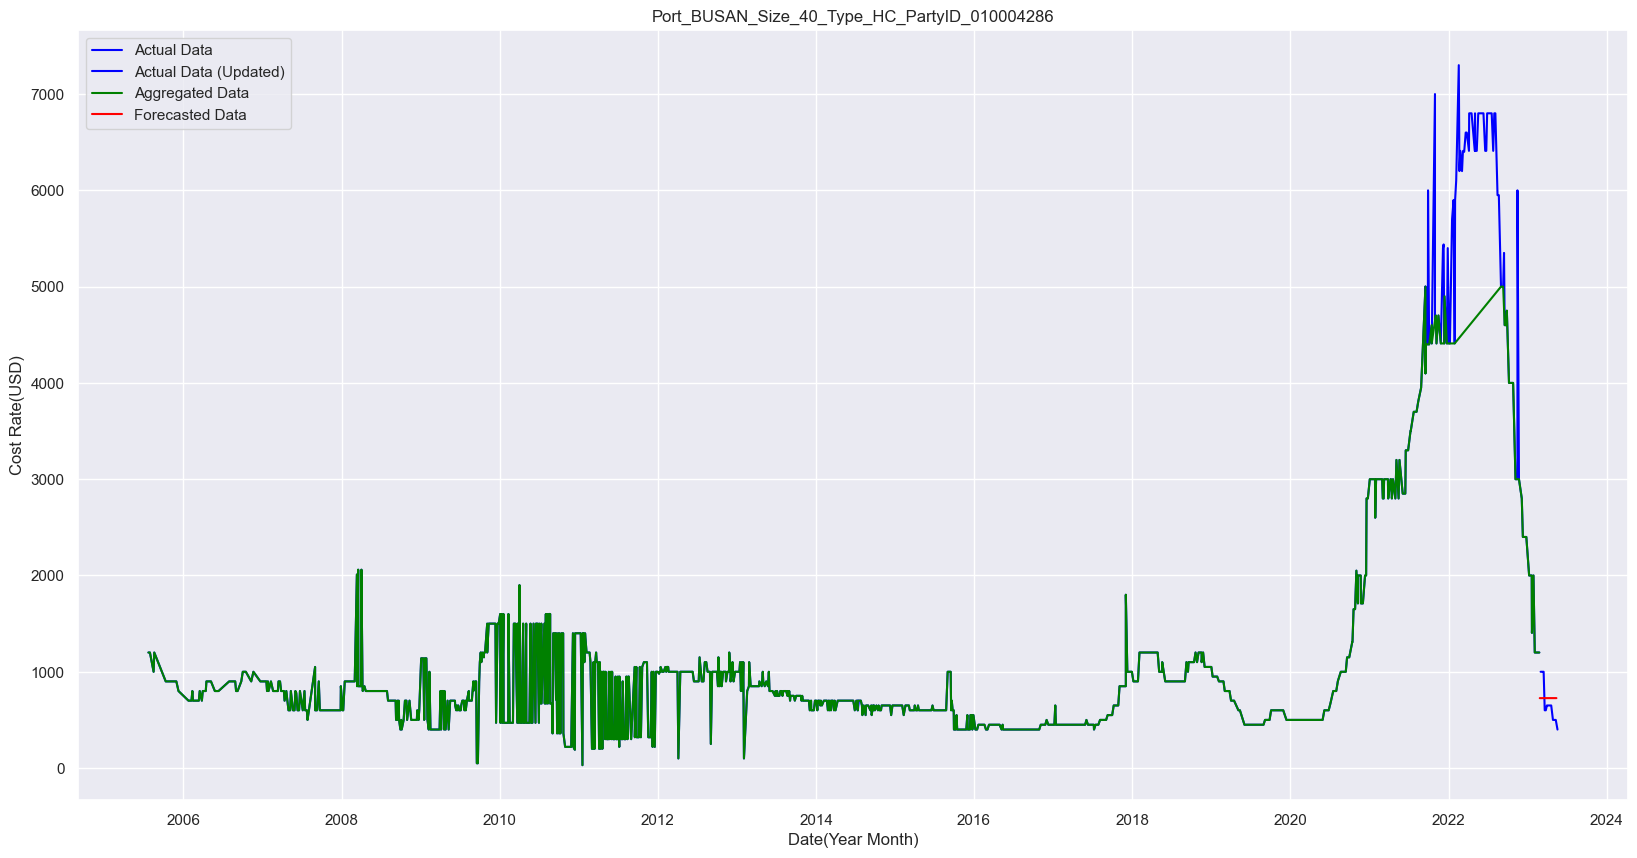

In [59]:
plt.figure(figsize=(20, 10))
plt.plot(sel_df['POD'], sel_df['RATE'], color='blue', label="Actual Data")
plt.plot(new_dates_df['POD'], new_dates_df['RATE'], color='blue', label="Actual Data (Updated)")

plt.plot(df_interpolated['POD'], df_interpolated['RATE'], color='green', label="Aggregated Data")
plt.plot(df_forecasted['POD'], df_forecasted['RATE'], color='red', label="Forecasted Data")

plt.xlabel('Date(Year Month)')
plt.ylabel('Cost Rate(USD)')
plt.title('Port_BUSAN_Size_40_Type_HC_PartyID_010004286')
plt.legend()
plt.show();